Reference
- [2015 Batch Normalization Paper](http://arxiv.org/pdf/1502.03167v3.pdf)
- [Blog 1](https://shuuki4.wordpress.com/2016/01/13/batch-normalization-%EC%84%A4%EB%AA%85-%EB%B0%8F-%EA%B5%AC%ED%98%84/)
- [Blog 2](http://r2rt.com/implementing-batch-normalization-in-tensorflow.html)
- [tf.contrib.layers.batch_norm]( https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L365)

# Simple implementation of Batch Normalization

In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
mnist = input_data.read_data_sets('MNIST/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST/t10k-labels-idx1-ubyte.gz


## Batch Normalization Transform
- Training
    - Normalize with batch mean and batch variance
    - Rescale with beta and gamma
    
    - Update mean and variance (moving average) of training data => for Test
    - Population mean/variance: estimate of mean/variance of general data
    
- Test
    - Normalize with population mean / population variance
    - Rescale with beta and gamma (same parameter used in training)

$$BN_{initial}(x_i) = \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}$$

$$BN(x_i) = \gamma(\frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}) + \beta$$

In [2]:
w1_initial = np.random.normal(size=(784, 100)).astype(np.float32)
w2_initial = np.random.normal(size=(100, 100)).astype(np.float32)
w3_initial = np.random.normal(size=(100, 10)).astype(np.float32)

epsilon = 1e-3

In [10]:
tf.reset_default_graph()

## Build Graph

In [11]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

## Graph without Batch Normalization

In [12]:
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x, w1) + b1
l1 = tf.nn.sigmoid(z1)

w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1, w2) + b2
l2 = tf.nn.sigmoid(z2)

w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(l2, w3)+b3)

cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Graph with Batch Normalization

In [13]:
# Layer 1
w1_BN = tf.Variable(w1_initial)
z1_BN = tf.matmul(x, w1_BN)

batch_mean1, batch_var1 = tf.nn.moments(z1_BN, [0])

# normalized z1
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

# Learnable parameters for rescale and shift
scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

# Rescale and Shift
BN1 = scale1 * z1_hat + beta1

l1_BN = tf.nn.sigmoid(BN1)

# Layer 2
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN, w2_BN)

batch_mean2, batch_var2 = tf.nn.moments(z2_BN, [0])

scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))

BN2 = tf.nn.batch_normalization(
    x=z2_BN,
    mean=batch_mean2,
    variance=batch_var2,
    offset=beta2,
    scale=scale2,
    variance_epsilon=epsilon)

l2_BN = tf.nn.sigmoid(BN2)

# Layer 3
w3_BN = tf.Variable(w3_initial)
b3_BN = tf.Variable(tf.zeros([10]))
y_BN = tf.nn.softmax(tf.matmul(l2_BN, w3_BN)+ b3_BN)

cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

correct_prediction_BN = tf.equal(tf.argmax(y_BN, 1), tf.argmax(y_, 1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN, tf.float32))

## Training

In [26]:
acc = []
acc_BN = []
layer2_activations = []
layer2_activations_BN = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in tqdm(range(40000)):
        batch = mnist.train.next_batch(60)
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})
        sess.run(train_step_BN, feed_dict={x: batch[0], y_: batch[1]})
        
        if i % 50 == 0:
            results = sess.run(
                [accuracy, accuracy_BN, z2, BN2],
                feed_dict={
                    x: mnist.test.images,
                    y_: mnist.test.labels,
                })
            acc.append(results[0])
            acc_BN.append(results[1])
            layer2_activations.append(np.mean(results[2], axis=0))
            layer2_activations_BN.append(np.mean(results[3], axis=0))
            
acc = np.array(acc)
acc_BN = np.array(acc_BN)
layer2_activations = np.array(layer2_activations)
layer2_activations_BN = np.array(layer2_activations_BN)

100%|██████████| 40000/40000 [04:00<00:00, 166.26it/s]


## Compare Accuracy

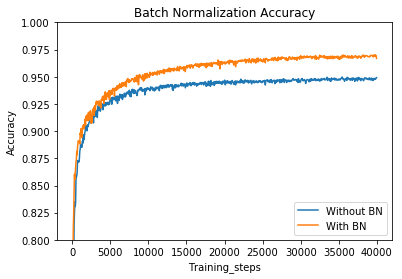

In [27]:
fig, ax = plt.subplots()

ax.plot(range(0, len(acc)*50, 50), acc, label='Without BN')
ax.plot(range(0, len(acc)*50, 50), acc_BN, label='With BN')
ax.set_xlabel('Training_steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8, 1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

## Activations of Layer2
- every 50 steps
- Sample: activations of 5 nodes right before sigmoid in layer 2

In [30]:
layer2_activations.shape

(800, 100)

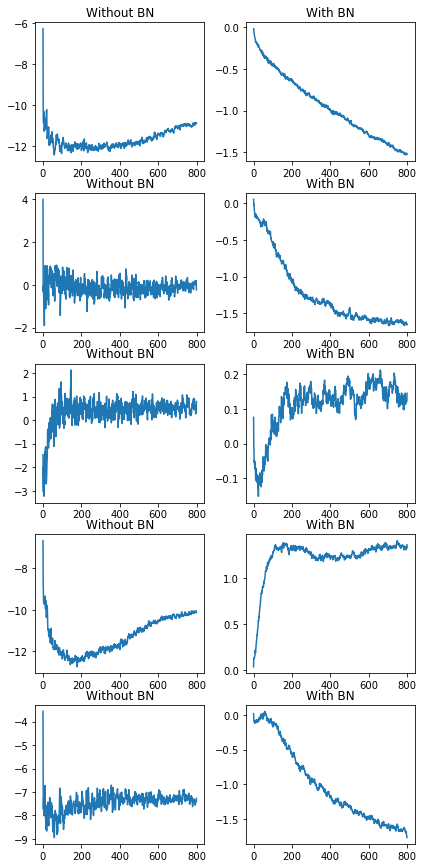

In [28]:
fig, axes = plt.subplots(5,2, figsize=(6, 12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title('Without BN')
    ax[1].set_title('With BN')
    ax[0].plot(layer2_activations[:, i])
    ax[1].plot(layer2_activations_BN[:, i])

# Using batch mean for single data is not working
- we subtract batch mean(=data) from data => 0
- activation function always get 0
- regardless of input, model will always have the same prediction

In [29]:
predictions = []
correct = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        pred, corr = sess.run([tf.argmax(y_BN, 1), accuracy_BN],
                             feed_dict={
                                 x: [mnist.test.images[i]],
                                 y_: [mnist.test.labels[i]]
                             })
        correct += corr
        predictions.append(pred[0])
print('Predictions:', predictions)
print('Accuracy:', correct/100)

Predictions: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Accuracy: 0.15


## Generalized batch norm wrapper

In [37]:
def batch_norm_wrapper(inputs, is_training, decay=0.999):
    """
    Simple Wrapper of `tf.contrib.layers.batch_norm`
    Training
    - Normalize with batch mean and batch variance
    - Rescale with beta and gamma
    
    - Update mean and variance (moving average) of training data => for Test
    - Population mean/variance: estimate of mean/variance of general data
    
    Test
    - Normalize with population mean / population variance
    - Rescale with beta and gamma (same parameter used in training)
    """
    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    
    
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    
    if is_training:
        batch_mean, batch_var = tf.nn.moments(inputs, [0])
        train_mean = tf.assign(pop_mean,
                               pop_mean*decay + batch_mean*(1-decay))
        train_var = tf.assign(pop_var,
                               pop_var*decay + batch_var*(1-decay))
        
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(
                x=inputs,
                mean=batch_mean,
                variance=batch_var,
                offset=beta,
                scale=scale,
                variance_epsilon=epsilon)
    else:
        return tf.nn.batch_normalization(
            x=inputs,
            mean=pop_mean,
            variance=pop_var,
            offset=beta,
            scale=scale,
            variance_epsilon=epsilon)

## Let's test our wrapper

In [40]:
def build_graph(is_training):
    # Placeholders
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # Layer 1
    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x, w1) # bias is useless
    bn1 = batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.sigmoid(bn1)

    # Layer 2
    w2 = tf.Variable(w2_initial)
    z2 = tf.matmul(l1, w2) # bias is useless
    bn2 = batch_norm_wrapper(z2, is_training) 
    l2 = tf.nn.sigmoid(bn2)

    # Softmax
    w3 = tf.Variable(w3_initial)
    b3 = tf.Variable(tf.zeros([10]))
    y = tf.nn.softmax(tf.matmul(l2, w3)+b3)

    # Loss, Optimizer and Predictions
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return (x, y_), train_step, accuracy, y, tf.train.Saver()

## Training

In [42]:
tf.reset_default_graph()
(x, y_), train_step, accuracy, y, saver = build_graph(is_training=True)

acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm(range(10000)):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 50 == 0:
            results = sess.run(
                [accuracy],
                feed_dict={
                    x: mnist.test.images,
                    y_: mnist.test.labels
                })
            acc.append(results[0])
    saved_model = saver.save(sess, './temp_bn_save')
print('Final Accuracy:', acc[-1])

100%|██████████| 10000/10000 [00:40<00:00, 265.65it/s]

Final Accuracy: 0.9524


## Test

In [43]:
tf.reset_default_graph()
(x, y_), train_step, accuracy, y, saver = build_graph(is_training=False)

predictions = []
correct = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './temp_bn_save')
    for i in range(100):
        pred, corr = sess.run(
            [tf.argmax(y, 1), accuracy],
            feed_dict={
                x: [mnist.test.images[i]],
                y_: [mnist.test.labels[i]],
            })
        correct += corr
        predictions.append(pred[0])
print('Predictions:', predictions)
print('Accuracy:', correct/100)

INFO:tensorflow:Restoring parameters from ./temp_bn_save
Predictions: [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9]
Accuracy: 0.99
